# Building the U-Net model for PM10 Prediction

This notebook contains the implementation of U-Net used in (Houdou, 2025) to forecast PM10 values in Morocco.

## Step 1 Load required libraries

In [ ]:
Provide the versions of the libraries:

i think nly tensorflow

In [144]:
import os
import glob
import pickle
import pandas as pd
import numpy as np
import xarray as xr

import tensorflow as tf
from tensorflow.keras import layers, models
#from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import r2_score
from scipy.stats import pearsonr

#import matplotlib.pyplot as plt

## Step 2 Read the data

This notebook uses pre-prepared data from CAMS. 
The data is of two kinds: one is the reanalysis data, which serves as observational or reference data and contains concentrations of PM10.
The other is forecast data, provided in the form of 8 NetCDF files containing forecasts for 8 predictors:
- PM10 – Particulate Matter with aerodynamic diameter ≤10 µm
- PM2.5 – Particulate Matter with aerodynamic diameter ≤2.5 µm
- PM1 – Particulate Matter with aerodynamic diameter ≤1 µm
- DAOD – Dust Aerosol Optical Depth at 550 nm
- 2mT – Temperature at 2 meters above the surface
- U10 – Zonal (east-west) wind component at 10 meters
- V10 – Meridional (north-south) wind component at 10 meters
- BLH – Boundary Layer Height

The data spans from 2015 to 2023, covering the entire domain of Morocco.

The forecast files are structured as follows:
- 3,287 forecast reference times (initialization days)
- 5 forecast periods (daily lead times)
- 43 latitude points
- 46 longitude points
  
The reanalysis data is structured as follows:
- 3,287 forecast reference times (initialization days)
- 5 forecast periods (daily lead times)
- 22 latitude points
- 23 longitude points

The reanalysis data was restructured to match the forecast data. Details about the processing steps can be found in (Houdou, 2025).

### Get the list of the files

In [35]:
# Path to the folder containing the .nc files
Folder = 'Path/to/the/data/folder/'
Folder = '../3 Process the data/data output/'

# Get a list of all .nc files in the folder
nc_files = glob.glob(Folder + '*.nc')
nc_files

['../3 Process the data/data output\\2mT.nc',
 '../3 Process the data/data output\\BLH.nc',
 '../3 Process the data/data output\\DAOD.nc',
 '../3 Process the data/data output\\PM1.nc',
 '../3 Process the data/data output\\PM10.nc',
 '../3 Process the data/data output\\PM25.nc',
 '../3 Process the data/data output\\U10.nc',
 '../3 Process the data/data output\\V10.nc']

### Load the data

In [36]:
# Read each .nc file and store them in a list of datasets
datasets = [xr.open_dataset(file_path) for file_path in nc_files]

In [7]:
datasets[0]

<xarray.Dataset> Size: 130MB
Dimensions:                  (forecast_reference_time: 3287,
                              forecast_period: 5, latitude: 43, longitude: 46)
Coordinates:
    valid_time               (forecast_reference_time, forecast_period) datetime64[ns] 131kB ...
  * forecast_period          (forecast_period) int32 20B 1 2 3 4 5
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 26kB 20...
  * latitude                 (latitude) float64 344B 36.8 36.4 ... 20.4 20.0
  * longitude                (longitude) float64 368B -18.0 -17.6 ... -0.4 0.0
Data variables:
    t2m                      (forecast_period, forecast_reference_time, latitude, longitude) float32 130MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-04T14:20 GRIB to CDM+CF via cfgrib-0.9.1...

In [37]:
#List of variables in the forecast dataset
list_var = [list(dataset.keys())[-1] for dataset in datasets]
list_var

['t2m', 'blh', 'duaod550', 'pm1', 'pm10', 'pm2p5', 'u10', 'v10']

In [38]:
#Read the reanalysis dataset
path_reanalysis = 'Path/to/the/reanalysis/file.nc/'
path_reanalysis = '../5 Build the model/Y_reanalysis.nc'
Y_reanalysis = xr.open_dataset(path_reanalysis)
Y_reanalysis

<xarray.Dataset> Size: 67MB
Dimensions:  (dim4: 5, dim3: 3287, dim2: 22, dim1: 23)
Dimensions without coordinates: dim4, dim3, dim2, dim1
Data variables:
    var1_1   (dim4, dim3, dim2, dim1) float64 67MB ...

In [39]:
list(Y_reanalysis.variables)

['var1_1']

### Remove the last 4 days

Remove the last 4 days as the reanalysis dataset contains NaN values.

In [41]:
# Remove the last 4 days of reanalysis
Y = Y_reanalysis.var1_1
Y = Y[:, :-4, :, :]
Y.shape

(5, 3283, 22, 23)

In [42]:
# Remove the last 4 days of the forecasts
list_array_X = [dataset[list_var[i]].values[:, :-4, :, :] for i, dataset in enumerate(datasets)]

In [43]:
for x in list_array_X:
    print(x.shape)

(5, 3283, 43, 46)
(5, 3283, 43, 46)
(5, 3283, 43, 46)
(5, 3283, 43, 46)
(5, 3283, 43, 46)
(5, 3283, 43, 46)
(5, 3283, 43, 46)
(5, 3283, 43, 46)


## Step 3 Normalizing the data

In [49]:
# Robust Scaling:
def robust_scaling(data, axis=None):
    median = np.median(data, axis=axis, keepdims=True)
    q1 = np.percentile(data, 25, axis=axis, keepdims=True)  # First quartile (25th percentile)
    q3 = np.percentile(data, 75, axis=axis, keepdims=True)  # Third quartile (75th percentile)
    iqr = q3 - q1  # Interquartile range

    return (data - median) / iqr, median, iqr   # return the median and iqr with the output to save and reuse in the inference step
    
# Logarithmic Transformation:
def log_transformation(data):
    return np.log(data + 1e-6)  # Adding a small constant to avoid log(0)


# Inverse transformation (to inverse the output of U-Net model)
def inverse_transform(output, median, iqr):
    # Step 1: Undo robust scaling
    output = (output * iqr) + median
    
    # Step 2: Undo log transformation
    output = np.exp(output) - 1e-6
    
    return output

In [53]:
# Logarithmic Transformation and then Robust Scaling for the Y variable (for PM10)
y_array_norm, median_y, iqr_y = robust_scaling(log_transformation(Y))
y_array_norm.shape

(5, 3283, 22, 23)

In [54]:
# Normalizing the for the X variables
list_var

['t2m', 'blh', 'duaod550', 'pm1', 'pm10', 'pm2p5', 'u10', 'v10']

In [55]:
# Logarithmic Transformation and then Robust Scaling for BLH, AOD, PM1, PM10, and PM2.5
blh, median_blh, iqr_blh = robust_scaling(log_transformation(list_array_X[1]), axis=(1, 2, 3)) # BLH
daod, median_aod, iqr_aod = robust_scaling(log_transformation(list_array_X[2]), axis=(1, 2, 3)) # DAOD
pm1, median_pm1, iqr_pm1 = robust_scaling(log_transformation(list_array_X[3]), axis=(1, 2, 3)) # PM1
pm10, median_pm10, iqr_pm10 = robust_scaling(log_transformation(list_array_X[4]), axis=(1, 2, 3)) # PM10
pm25, median_pm25, iqr_pm25 = robust_scaling(log_transformation(list_array_X[5]), axis=(1, 2, 3)) # PM25

# Robust Scaling for 2mT, U10, and V10
t2m, median_t, iqr_t = robust_scaling(list_array_X[0], axis=(1, 2, 3)) # 2mT
u10, median_u10, iqr_u10 = robust_scaling(list_array_X[6], axis=(1, 2, 3)) # U10
v10, median_v10, iqr_v10 = robust_scaling(list_array_X[7], axis=(1, 2, 3)) # V10

In [56]:
# Combining all vaibales into an array
X_array_norm = np.array((t2m, blh, daod, pm1, pm10, pm25, u10, v10))
X_array_norm.shape

(8, 5, 3283, 43, 46)

### Save the scaling parameters for the inference step

In [22]:
my_dict = {
    "Y_PM10": [median_y, iqr_y],
    "DAOD": [median_aod, iqr_aod],
    "PM1": [median_pm1, iqr_pm1],
    "PM10": [median_pm10, iqr_pm10],
    "PM25": [median_pm25, iqr_pm25],
    "BLH": [median_blh, iqr_blh],
    "2mT": [median_t, iqr_t],
    "U10": [median_u10, iqr_u10],
    "V10": [median_v10, iqr_v10]
}

# Save to file
with open("median_iqr.pkl", "wb") as f:
    pickle.dump(my_dict, f)

## Step 4 Adapt data for U-Net

### Adding a channel dimension to the Y variable

Adding a channel allows to match the shape of the predicted output of the network, and ensure compatibility with the loss function used for training.

In [57]:
# Add an extra dimension for the channel
y_array_norm = np.expand_dims(y_array_norm, axis=-1)    # (height, width, ...) becomes (height, width, ..., 1)
y_array_norm.shape

(5, 3283, 22, 23, 1)

### Adapte the channels for X

In [59]:
print(X_array_norm.shape)

(8, 5, 3283, 43, 46)


In [60]:
X_array_norm = X_array_norm.transpose(1, 2, 3, 4, 0)
print(X_array_norm.shape)

(5, 3283, 43, 46, 8)


## Step 5 Split the data into training and testing sets

In [61]:
# Find the position of the split date
position = np.where(datasets[0].forecast_reference_time.values == np.datetime64('2022-01-01'))
pos = position[0][0]

train_time = datasets[0].forecast_reference_time.values[0:pos]  # Training time from 2015 to 2021
test_time = datasets[0].forecast_reference_time.values[pos:]   # Testing time from 2022 to 2023

print(train_time.min(), train_time.max())
print(test_time.min(), test_time.max())

# Training data
X_train = X_array_norm[:, 0:pos, :, :, :]
X_test = X_array_norm[:, pos:, :, :, :]

# Testing data
y_train = y_array_norm[:, 0:pos, :, :, :]
y_test = y_array_norm[:, pos:, :, :, :]

2015-01-01T00:00:00.000000000 2021-12-31T00:00:00.000000000
2022-01-01T00:00:00.000000000 2023-12-31T00:00:00.000000000


In [65]:
print(X_train.shape)
print(X_test.shape)

(5, 2557, 43, 46, 8)
(5, 726, 43, 46, 8)


In [66]:
print(y_train.shape)
print(y_test.shape)

(5, 2557, 22, 23, 1)
(5, 726, 22, 23, 1)


## Step 6 Convert to Tensors

In [70]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

## Step 7 Define the U-Net Model

This U-Net architecture is modified to perform regression instead of segmentation. We changed the final activation to linear since PM10 concentrations are continuous values, and the loss function is the root mean squared error (RMSE).

The outputs of U-Net will be inversely transformed to obtain the exacte values of PM10.

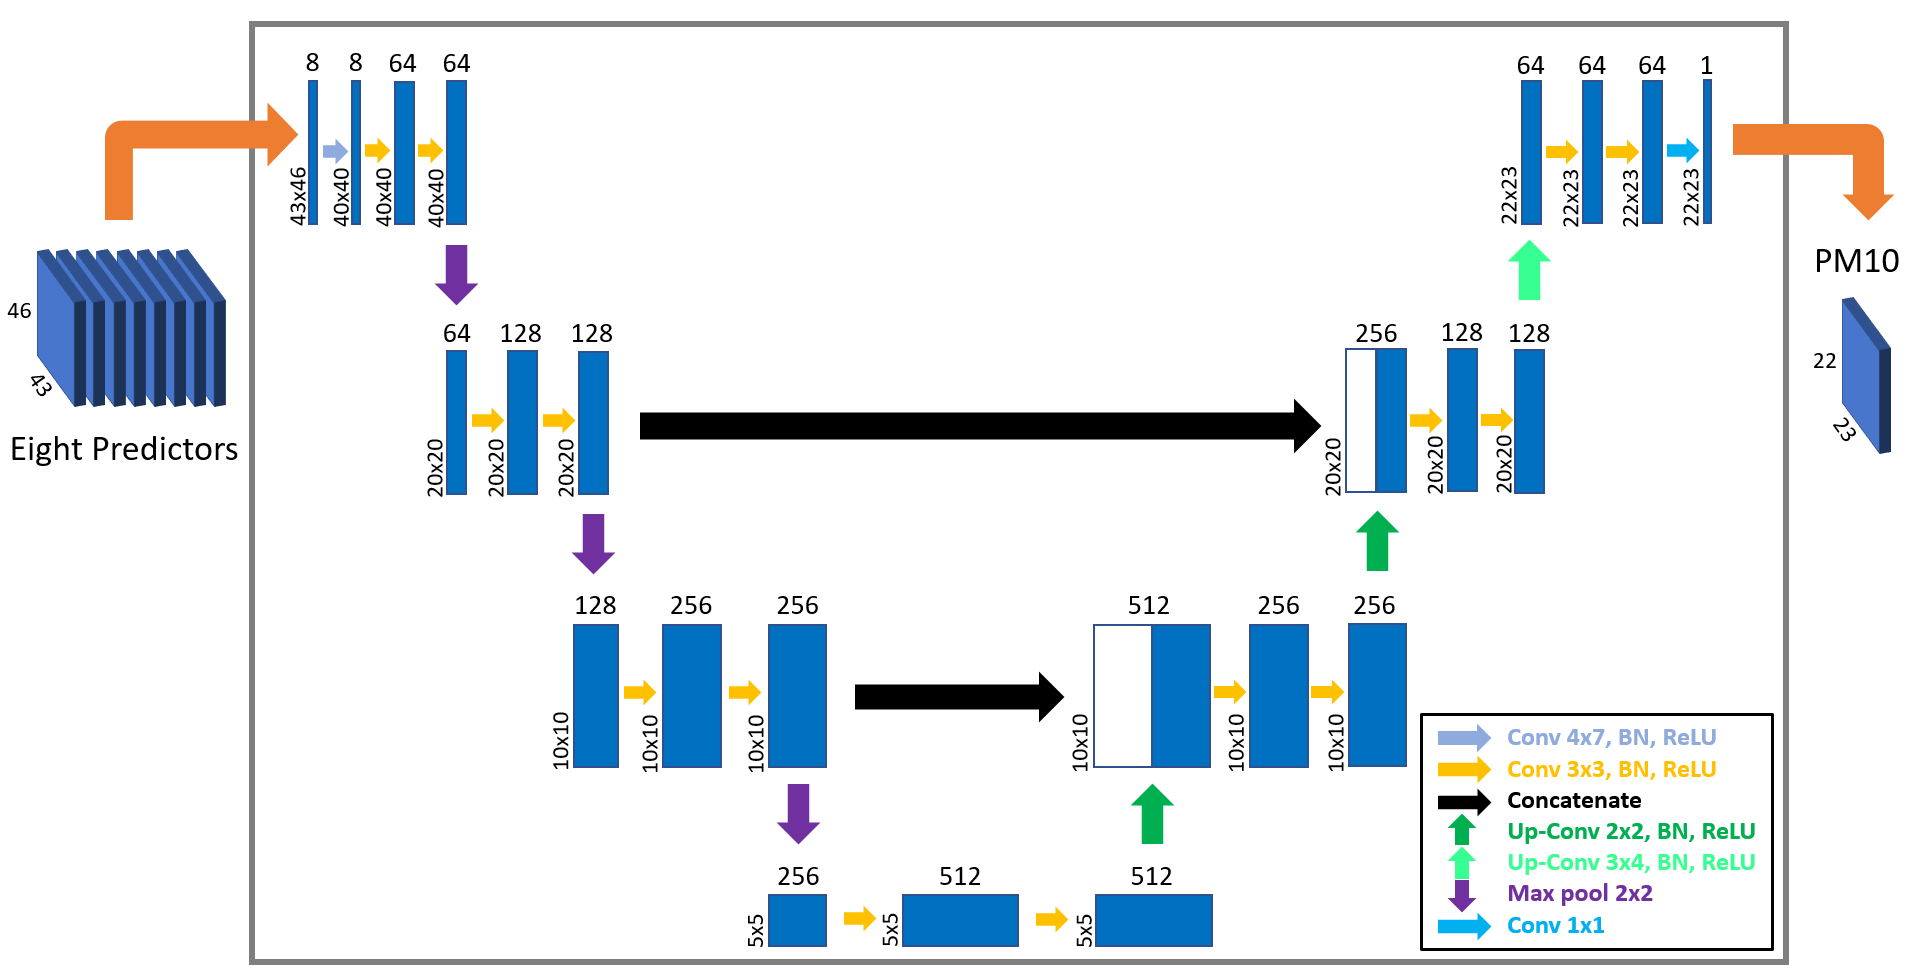

In [35]:
def unet_model(input_size=(43, 46, 8)):
    '''
    This function creates the U-Net model. 
    It consists of a downsampling (encoder) path followed by an upsampling (decoder) path.
    '''
    inputs = layers.Input(input_size) # Input layer with specified size

    # Encoder Path (Downsampling)
    conv1 = layers.Conv2D(filters=8, kernel_size=(4,7), padding='valid')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    
    conv1 = layers.Conv2D(64, 3, padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    
    conv1 = layers.Conv2D(64, 3, padding='same')(conv1) 
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)               
                                      
        
    conv2 = layers.Conv2D(128, 3, padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    
    conv2 = layers.Conv2D(128, 3, padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    
    conv3 = layers.Conv2D(256, 3, padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    
    conv3 = layers.Conv2D(256, 3, padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)


    # Bridge (Bottleneck)
    # This part connects the encoder and decoder paths.
    conv4 = layers.Conv2D(512, 3, padding='same')(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)
    conv4 = layers.Conv2D(512, 3, padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)

    # Decoder Path (Upsampling)
    # The feature maps from the encoder path are concatenated with the decoder maps.
    
    up5 = layers.Conv2DTranspose(filters=256, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = layers.BatchNormalization()(up5)
    up5 = layers.Activation('relu')(up5)
    merge5 = layers.concatenate([conv3, up5], axis=3)  
    
    conv5 = layers.Conv2D(256, 3, padding='same')(merge5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)
    
    conv5 = layers.Conv2D(256, 3, padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)
    

    up6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = layers.BatchNormalization()(up6)
    up6 = layers.Activation('relu')(up6)
    merge6 = layers.concatenate([conv2, up6], axis=3)
    
    conv6 = layers.Conv2D(128, 3, padding='same')(merge6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)
    
    conv6 = layers.Conv2D(128, 3, padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)
    

    up7 = layers.Conv2DTranspose(64, (3, 4), strides=(1, 1), padding='valid')(conv6)
    up7 = layers.BatchNormalization()(up7)
    up7 = layers.Activation('relu')(up7)
    
    conv7 = layers.Conv2D(64, 3, padding='same')(up7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)
    
    conv7 = layers.Conv2D(64, 3, padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)

    # Output layer for regression: A single channel with linear activation for PM2.5 prediction
    outputs = layers.Conv2D(1, 1, activation='linear')(conv7)
        
    # Create (Define) the model
    model = models.Model(inputs, outputs, name = 'U-Net')
    return model

In [36]:
# Create the U-Net model
unet = unet_model()

In [37]:
unet.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 43, 46, 8)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 40, 40, 8)         │           1,800 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 40, 40, 8)         │              32 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 40, 40, 8)         │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 40, 40, 64)        │           4,672 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 40, 40, 64)        │             256 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 40, 40, 64)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 40, 40, 64)        │          36,928 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 40, 40, 64)        │             256 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 40, 40, 64)        │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 20, 20, 64)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 20, 20, 128)       │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 20, 20, 128)       │             512 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 20, 20, 128)       │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 20, 20, 128)       │         147,584 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 7,743,785 (29.54 MB)

 Trainable params: 7,737,241 (29.52 MB)

 Non-trainable params: 6,544 (25.56 KB)

In [38]:
#plot_model(unet, "U-Net.png", show_shapes=True, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, show_layer_activations=True, dpi=300)

### Compile the model (Adding the Loss and Optimizer)

Compile the model for regression with Adam optimizer and root mean squared error (RMSE) as the loss function as indicated bellow.

Keras does not provide a built-in RMSE loss function directly. To use RMSE as a loss function, you can define a custom loss function as follows:

In [71]:
# RMSE loss function
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Adding R² (Coefficient of Determination) as a metric
def r2_metric(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - (ss_res / ss_tot)  # Add epsilon to avoid division by zero;  ss_tot + tf.keras.backend.epsilon()
    return r2

## Step 8 Training 5 Models (lead times 0 to 4)

- Train the U-Net models using the training set and validate it on the validation set.
- 5 models are being trained, 1 model for each lead-time (forecast period).

In [43]:
# Define the 5 models
unet_list = []

for i in range(5):
    # Create the U-Net model
    unet = unet_model()
    # Compile the model
    unet.compile(optimizer=Adam(learning_rate=0.0001),
                 loss=rmse,
                 metrics=['mae', r2_metric])
    unet_list.append(unet)


# To save the model with the lowest loss.
checkpoint_list = []
for i in range(5):
    checkpoint = ModelCheckpoint('results/LTs/best_model_LT_'+str(i)+'.keras', monitor='val_loss', save_best_only=True, mode='min')
    checkpoint_list.append(checkpoint)

In this example, we trained the models for three epochs only. To achieve convergence, the models were trained using 200 epochs in (Houdou, 2025).

In [44]:
%%time
# Run the models
history_df_list = []
for i in range(5):
    
    unet = unet_list[i]
    checkpoint = checkpoint_list[i]
    
    # Train the model
    history = unet.fit(X_train[i], y_train[i], validation_data=(X_test[i], y_test[i]), batch_size=10, epochs=3, callbacks=[checkpoint], shuffle=True, verbose='auto')
    
    # Save the model manually after training completes
    unet.save('results/LTs/trained_model_LT_'+str(i)+'.keras')
    
    # Save the losses
    history_df = pd.DataFrame(history.history)
    #history_df.to_excel('results/LTs/loss_metrics_LT_'+str(i)+'.xlsx', index=False)
    history_df_list.append(history_df)

Epoch 1/3
256/256 ━━━━━━━━━━━━━━━━━━━━ 147s 484ms/step - loss: 0.5413 - mae: 0.4353 - r2_metric: 0.0844 - val_loss: 0.4202 - val_mae: 0.3356 - val_r2_metric: 0.5673
Epoch 2/3
256/256 ━━━━━━━━━━━━━━━━━━━━ 122s 476ms/step - loss: 0.2612 - mae: 0.1975 - r2_metric: 0.8342 - val_loss: 0.2885 - val_mae: 0.2216 - val_r2_metric: 0.7832
Epoch 3/3
256/256 ━━━━━━━━━━━━━━━━━━━━ 116s 454ms/step - loss: 0.2421 - mae: 0.1834 - r2_metric: 0.8604 - val_loss: 0.3151 - val_mae: 0.2419 - val_r2_metric: 0.7400
Epoch 1/3
256/256 ━━━━━━━━━━━━━━━━━━━━ 141s 463ms/step - loss: 0.4914 - mae: 0.3800 - r2_metric: 0.2905 - val_loss: 0.4747 - val_mae: 0.3877 - val_r2_metric: 0.4459
Epoch 2/3
256/256 ━━━━━━━━━━━━━━━━━━━━ 121s 471ms/step - loss: 0.2732 - mae: 0.2080 - r2_metric: 0.8186 - val_loss: 0.2931 - val_mae: 0.2240 - val_r2_metric: 0.7818
Epoch 3/3
256/256 ━━━━━━━━━━━━━━━━━━━━ 122s 475ms/step - loss: 0.2520 - mae: 0.1918 - r2_metric: 0.8452 - val_loss: 0.2829 - val_mae: 0.2158 - val_r2_metric: 0.7940
Epoch 1/3


## Step 9 View the losses

In [46]:
history_df_list[0]

,loss,mae,r2_metric,val_loss,val_mae,val_r2_metric
0,0.366883,0.285514,0.596023,0.420237,0.335574,0.567299
1,0.255596,0.192920,0.841785,0.288524,0.221617,0.783170
2,0.239869,0.181251,0.860042,0.315096,0.241919,0.739978


In [50]:
def plot_losses(history_df):
    
    # Plot each metric in a separate subplot
    axe.plot(history_df[0].index+1, history_df[0]['val_loss'], label="Validation loss for FP 0", marker='o')
    axe.plot(history_df[0].index+1, history_df[1]['val_loss'], label="Validation loss for FP 1", marker='o')
    axe.plot(history_df[0].index+1, history_df[2]['val_loss'], label="Validation loss for FP 2", marker='o')
    axe.plot(history_df[0].index+1, history_df[3]['val_loss'], label="Validation loss for FP 3", marker='o')
    axe.plot(history_df[0].index+1, history_df[4]['val_loss'], label="Validation loss for FP 4", marker='o')

    axe.plot(history_df[0].index+1, history_df[0]['loss'], label="Training loss for FP 0", marker='o')
    axe.plot(history_df[0].index+1, history_df[1]['loss'], label="Training loss for FP 1", marker='o')
    axe.plot(history_df[0].index+1, history_df[2]['loss'], label="Training loss for FP 2", marker='o')
    axe.plot(history_df[0].index+1, history_df[3]['loss'], label="Training loss for FP 3", marker='o')
    axe.plot(history_df[0].index+1, history_df[4]['loss'], label="Training loss for FP 4", marker='o')
    
    #axe.set_title(title)
    axe.set_xlabel('Epoch')
    axe.set_ylabel('Values')
    axe.legend()

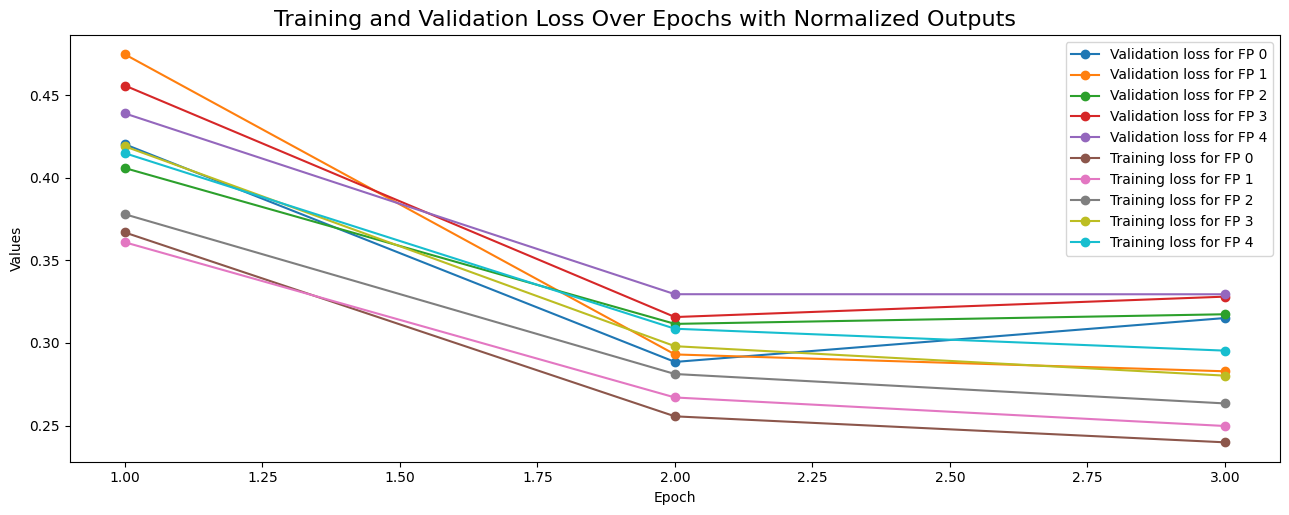

In [77]:
# Create subplots
fig, axe = plt.subplots(1, 1, figsize=(13, 5))  # 3 rows, 2 columns

plot_losses(history_df_list)

# Adjust layout
fig.tight_layout()
fig.suptitle('Training and Validation Loss Over Epochs with Normalized Outputs', fontsize=16, y=1.02)

# Show plot
plt.show()

## Step 10 Prediction and Evaluation

### Load the best trained models

In [73]:
# Load the model
unet_best_models = [models.load_model("results/LTs/best_model_LT_"+str(i)+".keras", custom_objects={'rmse': rmse, 'r2_metric': r2_metric}) for i in range(5)]

### Prediction 

In [81]:
X_test.shape

TensorShape([5, 726, 43, 46, 8])

In [82]:
y_pred = np.array([unet_best_models[i].predict(X_test[i]) for i in range(5)]).reshape(5, 726, 22, 23)

23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 454ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 435ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 440ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 471ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 440ms/step


In [162]:
# Inverse transformation
y_pred_inverse = inverse_transform(y_pred, median_y, iqr_y)
y_test_inverse = inverse_transform(y_test, median_y, iqr_y)

In [114]:
y_pred_inverse.shape

(5, 726, 22, 23)

In [160]:
y_test_inverse.shape

(5, 726, 22, 23, 1)

In [120]:
y_test_inverse = y_test_inverse.reshape(5, 726, 22,-1)
y_test_inverse.shape

(5, 726, 22, 23)

### Use the initial PM10 forecasts for comparison

In [134]:
dataset_pm10_forecasts = datasets[4].isel(forecast_reference_time=slice(0, -4))   # Remove last 4 days
dataset_pm10_forecasts = dataset_pm10_forecasts.sel(forecast_reference_time=slice("2022-01-01", "2023-12-31"))  # Select the data for the test period

#regrid the file (Interpolate the dataset onto the new latitude and longitude coordinates)

lat = np.array([36.21, 35.46, 34.71, 33.96, 33.21, 32.46, 31.71, 30.96, 30.21,
       29.46, 28.71, 27.96, 27.21, 26.46, 25.71, 24.96, 24.21, 23.46,
       22.71, 21.96, 21.21, 20.46])
lon = np.array([-17.49, -16.74, -15.99, -15.24, -14.49, -13.74, -12.99, -12.24,
       -11.49, -10.74,  -9.99,  -9.24,  -8.49,  -7.74,  -6.99,  -6.24,
        -5.49,  -4.74,  -3.99,  -3.24,  -2.49,  -1.74,  -0.99])

dataset_pm10_forecasts = dataset_pm10_forecasts.interp(latitude=lat, longitude=lon, method='nearest')
dataset_pm10_forecasts

<xarray.Dataset> Size: 7MB
Dimensions:                  (forecast_reference_time: 726, forecast_period: 5,
                              latitude: 22, longitude: 23)
Coordinates:
    valid_time               (forecast_reference_time, forecast_period) datetime64[ns] 29kB ...
  * forecast_period          (forecast_period) int32 20B 1 2 3 4 5
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 6kB 202...
  * latitude                 (latitude) float64 176B 36.21 35.46 ... 21.21 20.46
  * longitude                (longitude) float64 184B -17.49 -16.74 ... -0.99
Data variables:
    pm10                     (forecast_period, forecast_reference_time, latitude, longitude) float32 7MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-04T14:19 GRIB to CDM+CF via cfgrib-0.9.1...

In [138]:
dataset_pm10_forecasts.pm10.values.shape

(5, 726, 22, 23)

### Evaluating the performance of the model overall

In [154]:
def calculate_metrics(array_1, array_2):
    
    mae = np.mean(np.abs(array_1 - array_2)) # Mean Absolute Error (MAE)
    rmse = np.sqrt(np.mean((array_1 - array_2)**2)) # Root Mean Squared Error (RMSE)
    bias = np.mean(array_2) - np.mean(array_1) # Bias = fore - obs
    
    array_1 = array_1.reshape(-1)
    array_2 = array_2.reshape(-1)
    
    r2 = r2_score(array_1, array_2) # R-squared (R2)
    r, _ = pearsonr(array_1, array_2) # Pearson Correlation Coefficient (R)
    
    return mae, rmse, bias, r2*100, r

In [146]:
# MAE, RMSE, Bias, R2, R
metrics_list = []
metrics_list_ = []
list_names = ['U-net', 'CAMS Forecasts']
for pred in (y_pred_inverse, dataset_pm10_forecasts.pm10.values):
    # For the year 2022
    MAE, RMSE, Bias, R2, R = calculate_metrics(y_test_inverse[:, :365, :, :], pred[:, :365, :, :])
    metrics_list.append((MAE, RMSE, Bias, R2, R))
    # For the year 2023
    MAE_, RMSE_, Bias_, R2_, R_ = calculate_metrics(y_test_inverse[:, 365:, :, :], pred[:, 365:, :, :])
    metrics_list_.append((MAE_, RMSE_, Bias_, R2_, R_))

In [148]:
df_2022 = pd.DataFrame(columns = ['MAE (µg/m³)', 'RMSE (µg/m³)', 'Bias (µg/m³)', 'R2 (%)', 'Pearson r'])

for k in range(2):
    df_2022.loc[list_names[k]] = metrics_list[k]

df_2022 = df_2022.round(2)
df_2022

,MAE (µg/m³),RMSE (µg/m³),Bias (µg/m³),R2 (%),Pearson r
U-net,21.28,38.12,-5.17,69.70,0.84
CAMS Forecasts,33.31,53.57,5.88,40.16,0.69


In [150]:
df_2023 = pd.DataFrame(columns = ['MAE (µg/m³)', 'RMSE (µg/m³)', 'Bias (µg/m³)', 'R2 (%)', 'Pearson r'])

for k in range(2):
    df_2023.loc[list_names[k]] = metrics_list_[k]

df_2023 = df_2023.round(2)
df_2023

,MAE (µg/m³),RMSE (µg/m³),Bias (µg/m³),R2 (%),Pearson r
U-net,24.76,46.71,8.19,50.87,0.81
CAMS Forecasts,57.87,114.59,42.32,-195.66,0.63
